In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/')

# Importing libraries


In [60]:
## for data
import json
import pandas as pd
import numpy as np
import os
from numpy import sort

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(rc={'figure.figsize': [10, 7]}, font_scale=1.0)

## for processing and feature engineering
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
import re
from sklearn.feature_extraction.text import TfidfVectorizer



## For Model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

## For Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import ndcg_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MElBa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Helper Functions


In [61]:
def extract_date_features(df):
    """Handling the date to get important features"""
    df['weekday_account_created'] = df.date_account_created.dt.weekday
    df['month_account_created'] = df.date_account_created.dt.month
    df['year_account_created'] = df.date_account_created.dt.year
    
    df['weekday_first_active'] = df.timestamp_first_active.dt.weekday
    df['month_first_active'] = df.timestamp_first_active.dt.month
    df['year_first_active'] = df.timestamp_first_active.dt.year
    df['hour_first_active'] = df.timestamp_first_active.dt.hour

    df['time_lag'] = (df['date_account_created'] - df['timestamp_first_active'])
    df['time_lag'] = df['time_lag'].apply(lambda x:x.days)
    df.drop(['date_account_created', 'timestamp_first_active'], axis=1,inplace=True)
    
    return df


def set_age_group(x):
    "Convert the age from numerical to 4 categpry"
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'
    
    
def languages(df):
    ""
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df



def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'other' if x not in ['direct', 'google', 'other'] else x)
    return df

def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df
def affiliate_handling(df):
    " Affiliate handling"
    df=affiliate_tracked(df)
    df=affiliate_provider(df)
    df=affiliate_channel(df)
    return df



def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'
    




# Get the data

In [62]:
# Let us load the data now.
# sessions=pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/datasets/afterCleaning/sessions_v2.p')
# countries=pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/datasets/afterCleaning/countries_v2.p')
# age_gender=pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/datasets/afterCleaning/age_gender_bkts_v2.p')


# train_users=pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/datasets/afterCleaning/train_users_2_v2.p')
# test_users=pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/Airbnb New User Bookings/datasets/afterCleaning/test_users_v2.p')




# Let us load the data now. (Local)
sessions=pd.read_pickle('./datasets/afterCleaning/sessions_v2.p')
countries=pd.read_pickle('./datasets/afterCleaning/countries_v2.p')
age_gender=pd.read_pickle('./datasets/afterCleaning/age_gender_bkts_v2.p')


train_users=pd.read_pickle('./datasets/afterCleaning/train_users_2_v1.p')
test_users=pd.read_pickle('./datasets/afterCleaning/test_users_v2.p')


# Prepare the Data


### Let us make feature engineering for the sessions dataset

In [63]:
print("length of unique user id :",len(sessions.user_id.unique()))
print("length of all user id :",len(sessions.user_id))

length of unique user id : 135483
length of all user id : 10533241


In [64]:
sessions = sessions.dropna(subset = ['user_id'])

In [65]:
sessions['action_type']=sessions['action_type'].fillna('Unknown')
sessions['action_detail']=sessions['action_detail'].fillna('Unknown')
sessions['device_type']=sessions['device_type'].fillna('Unknown')
sessions['action']=sessions['action'].fillna('Unknown')
sessions['action_type']=sessions['action_type'].replace('-unknown-','Unknown')



In [66]:
sessions[['action','action_type','action_detail','device_type']].head()

,action,action_type,action_detail,device_type
0,lookup,Unknown,Unknown,Windows Desktop
1,search_results,click,view_search_results,Windows Desktop
2,lookup,Unknown,Unknown,Windows Desktop
3,search_results,click,view_search_results,Windows Desktop
4,lookup,Unknown,Unknown,Windows Desktop


In [67]:
sessions.groupby(['user_id', 'action'])['secs_elapsed'].agg(['count'])

count
user_id    action                      
00023iyk9l Unknown                    1
           ajax_refresh_subtotal      2
           callback                   0
           confirm_email              1
           dashboard                  4
...                                 ...
zzzlylp57e personalize                6
           requested                  5
           search_results            10
           show                      14
           similar_listings           9

[1775850 rows x 1 columns]

In [68]:
action_Count=sessions.groupby(['user_id', 'action'])['secs_elapsed'].agg(['count']).unstack().fillna(0).reset_index()
action_Count = action_Count.add_suffix('_Count')
action_Count.columns = action_Count.columns.droplevel(0)
action_Count=action_Count.rename(columns={'_Count': 'id'})
action_Count.head()

action,id,10_Count,11_Count,12_Count,15_Count,Unknown_Count,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,listings_Count,load_more_Count,locale_from_host_Count,localization_settings_Count,localized_Count,locations_Count,login_Count,login_modal_Count,lookup_Count,manage_listing_Count,maybe_information_Count,media_resources_Count,message_Count,message_to_host_change_Count,message_to_host_focus_Count,mobile_landing_page_Count,mobile_oauth_callback_Count,multi_Count,multi_message_Count,multi_message_attributes_Count,my_Count,my_listings_Count,my_reservations_Count,new_Count,new_host_Count,new_session_Count,n

In [153]:
action_Sum=sessions.groupby(['user_id', 'action_type'])['secs_elapsed'].agg(['sum']).unstack().fillna(0).reset_index()
action_Sum = action_Sum.add_suffix('_Sum')
action_Sum.columns = action_Sum.columns.droplevel(0)
action_Sum=action_Sum.rename(columns={'_Sum': 'id'})
action_Sum.head()

action_type,id,Unknown_Sum,booking_request_Sum,booking_response_Sum,click_Sum,data_Sum,message_post_Sum,modify_Sum,partner_callback_Sum,submit_Sum,view_Sum
0,00023iyk9l,977.0,0.0,0.0,590691.0,7043.0,129817.0,0.0,0.0,0.0,139368.0
1,0010k6l0om,124147.0,0.0,0.0,65954.0,136246.0,0.0,0.0,0.0,0.0,260196.0
2,001wyh0pz8,27197.0,0.0,0.0,158796.0,1550.0,0.0,0.0,0.0,50906.0,44516.0
3,0028jgx1x1,489.0,0.0,0.0,199802.0,8603.0,0.0,0.0,0.0,0.0,88116.0
4,002qnbzfs5,3330347.0,70986.0,0.0,644323.0,293735.0,325235.0,0.0,0.0,1537719.0,284735.0


In [70]:
actions= action_Sum.merge(action_Count,left_on='id', right_on='id', how='inner')

In [71]:
action_type_Count=sessions.groupby(['user_id', 'action_type'])['secs_elapsed'].agg(['count']).unstack().fillna(0).reset_index()
action_type_Count = action_type_Count.add_suffix('_Count')
action_type_Count.columns = action_type_Count.columns.droplevel(0)
action_type_Count=action_type_Count.rename(columns={'_Count': 'id'})
action_type_Count.head()

action_type,id,Unknown_Count,booking_request_Count,booking_response_Count,click_Count,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count
0,00023iyk9l,3.0,1.0,0.0,4.0,9.0,1.0,0.0,0.0,0.0,21.0
1,0010k6l0om,20.0,0.0,0.0,16.0,9.0,0.0,0.0,0.0,0.0,17.0
2,001wyh0pz8,11.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,2.0,8.0
3,0028jgx1x1,1.0,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0,15.0
4,002qnbzfs5,260.0,1.0,0.0,140.0,140.0,16.0,0.0,0.0,15.0,216.0


In [72]:
action_type_Sum=sessions.groupby(['user_id', 'action_type'])['secs_elapsed'].agg(['sum']).unstack().fillna(0).reset_index()
action_type_Sum = action_type_Sum.add_suffix('_Sum')
action_type_Sum.columns = action_type_Sum.columns.droplevel(0)
action_type_Sum=action_type_Sum.rename(columns={'_Sum': 'id'})
action_type_Sum.head()

action_type,id,Unknown_Sum,booking_request_Sum,booking_response_Sum,click_Sum,data_Sum,message_post_Sum,modify_Sum,partner_callback_Sum,submit_Sum,view_Sum
0,00023iyk9l,977.0,0.0,0.0,590691.0,7043.0,129817.0,0.0,0.0,0.0,139368.0
1,0010k6l0om,124147.0,0.0,0.0,65954.0,136246.0,0.0,0.0,0.0,0.0,260196.0
2,001wyh0pz8,27197.0,0.0,0.0,158796.0,1550.0,0.0,0.0,0.0,50906.0,44516.0
3,0028jgx1x1,489.0,0.0,0.0,199802.0,8603.0,0.0,0.0,0.0,0.0,88116.0
4,002qnbzfs5,3330347.0,70986.0,0.0,644323.0,293735.0,325235.0,0.0,0.0,1537719.0,284735.0


In [73]:
action_types = action_type_Sum.merge(action_type_Count,left_on='id', right_on='id', how='inner')


In [74]:
session_df_grouped =action_types.merge(actions,left_on='id', right_on='id', how='inner')
session_df_grouped

,id,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,listings_Count,loa

In [156]:
session_df_grouped.iloc[:,1:]

,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,listings_Count,load_m

In [157]:
scaller=StandardScaler()
session_df_grouped.iloc[:,1:]=scaller.fit_transform(session_df_grouped.iloc[:,1:])
session_df_grouped

,id,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,listings_Count,loa

In [158]:
session_df_grouped.isna().sum()

id                                                       0
Unknown_Sum_x                                            0
booking_request_Sum_x                                    0
booking_response_Sum_x                                   0
click_Sum_x                                              0
data_Sum_x                                               0
message_post_Sum_x                                       0
modify_Sum_x                                             0
partner_callback_Sum_x                                   0
submit_Sum_x                                             0
view_Sum_x                                               0
Unknown_Count_x                                          0
booking_request_Count                                    0
booking_response_Count                                   0
click_Count_x                                            0
data_Count                                               0
message_post_Count                                      

So **no need** to use the imputed secs_elapsed column.

### Let us make feature engineering for the Training and Test Users dataset

In [159]:
train_users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [77]:
train_users.shape

(213451, 15)

In [160]:
test_users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaN,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaN,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaN,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaN,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [161]:
train_merge = train_users.merge(session_df_grouped,left_on='id', right_on='id', how='inner')

test_merge = test_users.merge(session_df_grouped, left_on='id', right_on='id', how='left')


In [162]:
train_merge.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Co

In [163]:
test_merge.shape

(62096, 404)

In [164]:
train_merge.isna().sum()

id                                                           0
date_account_created                                         0
timestamp_first_active                                       0
gender                                                   37788
age                                                      32622
signup_method                                                0
signup_flow                                                  0
language                                                     0
affiliate_channel                                            0
affiliate_provider                                           0
first_affiliate_tracked                                    302
signup_app                                                   0
first_device_type                                            0
first_browser                                            12271
country_destination                                          0
Unknown_Sum_x                                          

In [165]:
test_merge.isna().sum()

id                                                           0
date_account_created                                         0
timestamp_first_active                                       0
gender                                                   33792
age                                                      29110
signup_method                                                0
signup_flow                                                  0
language                                                     1
affiliate_channel                                            0
affiliate_provider                                           0
first_affiliate_tracked                                     20
signup_app                                                   0
first_device_type                                            0
first_browser                                            17128
Unknown_Sum_x                                              428
booking_request_Sum_x                                  

In [166]:
test_merge.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider',
       ...
       'view_Count_y', 'views_Count', 'views_campaign_Count', 'views_campaign_rules_Count', 'webcam_upload_Count', 'weibo_signup_referral_finish_Count', 'why_host_Count', 'widget_Count', 'wishlists_Count', 'zendesk_login_jwt_Count'], dtype='object', length=404)

In [167]:
data = pd.concat((train_merge, test_merge), axis=0, ignore_index=True)

**Date Features**

In [168]:
data=extract_date_features(data)


In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135911 entries, 0 to 135910
Columns: 411 entries, id to time_lag
dtypes: float64(391), int64(9), object(11)
memory usage: 426.2+ MB


In [170]:
data.shape

(135911, 411)

In [171]:
data.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_C

In [172]:
df=data.copy()

## Handling Numerical Attributes


In [174]:
Num_Features=['id', 'age']
Num_df=df[Num_Features]

In [175]:
Num_df['age_group'] = Num_df.age.apply(set_age_group)
Num_df.drop(columns='age',inplace=True)

C:\Users\MElBa\AppData\Local\Temp\ipykernel_13524\63505515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Num_df['age_group'] = Num_df.age.apply(set_age_group)
C:\Users\MElBa\AppData\Local\Temp\ipykernel_13524\63505515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Num_df.drop(columns='age',inplace=True)


In [176]:
Num_df.head()

,id,age_group
0,d1mm9tcy42,Old
1,yo8nz8bqcq,Unknown
2,4grx6yxeby,Unknown
3,ncf87guaf0,Unknown
4,4rvqpxoh3h,Unknown


In [177]:
df.drop(columns=['age'],inplace=True)
df=df.merge(Num_df,on='id')
df.head()

,id,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count

## Handling Categorical Attributes


In [178]:
df['gender'].fillna('Unknown', inplace=True)
df=languages(df)
df=affiliate_handling(df)
df = browsers(df)
df.set_index("id",inplace=True)

In [179]:
df.isna().sum()

gender                                                       0
signup_method                                                0
signup_flow                                                  0
language                                                     0
affiliate_channel                                            0
affiliate_provider                                           0
first_affiliate_tracked                                      0
signup_app                                                   0
first_device_type                                            0
first_browser                                                0
country_destination                                      62096
Unknown_Sum_x                                              428
booking_request_Sum_x                                      428
booking_response_Sum_x                                     428
click_Sum_x                                                428
data_Sum_x                                             

In [180]:
df=df.fillna(0)

In [181]:
df.columns

Index(['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
       ...
       'zendesk_login_jwt_Count', 'weekday_account_created', 'month_account_created', 'year_account_created', 'weekday_first_active', 'month_first_active', 'year_first_active', 'hour_first_active', 'time_lag', 'age_group'], dtype='object', length=410)

In [182]:
cols=['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_browser', 'country_destination', 'first_device_type', 'weekday_account_created', 'month_account_created', 'year_account_created', 'weekday_first_active', 'month_first_active', 'year_first_active']

In [183]:
for i in cols:
    df[i]=df[i].astype("category")

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135911 entries, d1mm9tcy42 to 9uqfg8txu3
Columns: 410 entries, gender to age_group
dtypes: category(17), float64(390), int64(2), object(1)
memory usage: 410.8+ MB


In [185]:
ohe = ['gender', 'signup_flow','weekday_account_created','age_group','month_account_created','weekday_first_active','month_first_active','signup_method', 'language','year_account_created','year_first_active' ,'affiliate_channel','first_device_type','affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_browser']
DF=pd.get_dummies(df,columns=ohe)
DF.head()

,country_destination,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,l

In [186]:
DF.isna().sum()

country_destination                                      0
Unknown_Sum_x                                            0
booking_request_Sum_x                                    0
booking_response_Sum_x                                   0
click_Sum_x                                              0
data_Sum_x                                               0
message_post_Sum_x                                       0
modify_Sum_x                                             0
partner_callback_Sum_x                                   0
submit_Sum_x                                             0
view_Sum_x                                               0
Unknown_Count_x                                          0
booking_request_Count                                    0
booking_response_Count                                   0
click_Count_x                                            0
data_Count                                               0
message_post_Count                                      

# Splitting train and test

In [187]:
train_df = DF.loc[train_merge['id']]
test_df = DF.loc[test_merge['id']].drop('country_destination', axis=1)

train_df=train_df.reset_index()
id_train = train_df['id']
train_df.drop(columns=['id'], inplace=True)



test_df=test_df.reset_index()
id_test = test_df['id']
test_df.drop(columns=['id'], axis=1, inplace=True)





In [188]:

y_train = train_df['country_destination']
x_train=train_df.drop(['country_destination'], axis=1)

#Transforming the target variable using labels
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)





In [107]:
x_train.head()

,Unknown_Sum_x,booking_request_Sum_x,booking_response_Sum_x,click_Sum_x,data_Sum_x,message_post_Sum_x,modify_Sum_x,partner_callback_Sum_x,submit_Sum_x,view_Sum_x,Unknown_Count_x,booking_request_Count,booking_response_Count,click_Count_x,data_Count,message_post_Count,modify_Count,partner_callback_Count,submit_Count,view_Count_x,Unknown_Sum_y,booking_request_Sum_y,booking_response_Sum_y,click_Sum_y,data_Sum_y,message_post_Sum_y,modify_Sum_y,partner_callback_Sum_y,submit_Sum_y,view_Sum_y,10_Count,11_Count,12_Count,15_Count,Unknown_Count_y,about_us_Count,accept_decline_Count,account_Count,acculynk_bin_check_failed_Count,acculynk_bin_check_success_Count,acculynk_load_pin_pad_Count,acculynk_pin_pad_error_Count,acculynk_pin_pad_inactive_Count,acculynk_pin_pad_success_Count,acculynk_session_obtained_Count,active_Count,add_business_address_colorbox_Count,add_guest_colorbox_Count,add_guests_Count,add_note_Count,agree_terms_check_Count,agree_terms_uncheck_Count,airbnb_picks_Count,airbrb_Count,ajax_check_dates_Count,ajax_get_referrals_amt_Count,ajax_get_results_Count,ajax_google_translate_Count,ajax_google_translate_description_Count,ajax_google_translate_reviews_Count,ajax_image_upload_Count,ajax_ldp_Count,ajax_lwlb_contact_Count,ajax_payout_edit_Count,ajax_payout_options_by_country_Count,ajax_payout_split_edit_Count,ajax_photo_widget_Count,ajax_photo_widget_form_iframe_Count,ajax_price_and_availability_Count,ajax_referral_banner_experiment_type_Count,ajax_referral_banner_type_Count,ajax_refresh_subtotal_Count,ajax_send_message_Count,ajax_special_offer_dates_available_Count,ajax_statsd_Count,ajax_worth_Count,apply_Count,apply_code_Count,apply_coupon_click_Count,apply_coupon_click_success_Count,apply_coupon_error_Count,apply_coupon_error_type_Count,apply_reservation_Count,approve_Count,ask_question_Count,at_checkpoint_Count,authenticate_Count,authorize_Count,available_Count,badge_Count,become_user_Count,book_Count,booking_Count,braintree_client_token_Count,business_travel_Count,calendar_tab_inner2_Count,callback_Count,campaigns_Count,cancel_Count,cancellation_policies_Count,cancellation_policy_click_Count,change_Count,change_availability_Count,change_currency_Count,change_default_payout_Count,change_password_Count,check_Count,city_count_Count,clear_reservation_Count,click_Count_y,clickthrough_Count,collections_Count,complete_Count,complete_redirect_Count,complete_status_Count,concierge_Count,confirm_email_Count,confirmation_Count,connect_Count,contact_new_Count,countries_Count,country_options_Count,coupon_code_click_Count,coupon_field_focus_Count,create_Count,create_ach_Count,create_airbnb_Count,create_multiple_Count,create_paypal_Count,currencies_Count,custom_recommended_destinations_Count,dashboard_Count,deactivate_Count,deactivated_Count,deauthorize_Count,decision_tree_Count,delete_Count,department_Count,departments_Count,desks_Count,destroy_Count,detect_fb_session_Count,disaster_action_Count,domains_Count,edit_Count,edit_verification_Count,email_by_key_Count,email_itinerary_colorbox_Count,email_share_Count,email_wishlist_Count,endpoint_error_Count,envoy_bank_details_redirect_Count,envoy_form_Count,events_Count,facebook_auto_login_Count,faq_Count,faq_category_Count,faq_experiment_ids_Count,feed_Count,forgot_password_Count,founders_Count,friend_listing_Count,friends_Count,friends_new_Count,glob_Count,google_importer_Count,guarantee_Count,guest_billing_receipt_Count,guest_booked_elsewhere_Count,handle_vanity_url_Count,hard_fallback_submit_Count,has_profile_pic_Count,header_userpic_Count,home_safety_landing_Count,home_safety_terms_Count,hospitality_Count,hospitality_standards_Count,host_2013_Count,host_cancel_Count,host_summary_Count,hosting_social_proof_Count,how_it_works_Count,identity_Count,image_order_Count,impressions_Count,index_Count,invalid_action_Count,issue_Count,itinerary_Count,jumio_Count,jumio_redirect_Count,jumio_token_Count,kba_Count,kba_update_Count,languages_multiselect_Count,life_Count,listing_Count,listings_Count,load_m

In [190]:
X_train, X_test, y_train, y_test = train_test_split(x_train, encoded_y_train, train_size=0.75, stratify=encoded_y_train)

# Model Selection

## Decision Tree

In [191]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predDT_train = DT.predict_proba(X_train)  
y_train_matrix = np.zeros(shape=(y_predDT_train.shape[0], y_predDT_train.shape[1]))
y_train_matrix[np.arange(y_predDT_train.shape[0]), y_train] = 1
print("NDCG Score of {}is {} for train".format(DT,ndcg_score(y_train_matrix,y_predDT_train,k=5)))

print("="*50)
y_predDT_test = DT.predict_proba(X_test)  

y_test_matrix = np.zeros(shape=(y_predDT_test.shape[0], y_predDT_test.shape[1]))
y_test_matrix[np.arange(y_predDT_test.shape[0]), y_test] = 1
print("NDCG Score of {}is {} for test".format(DT,ndcg_score(y_test_matrix,y_predDT_test,k=5)))

NDCG Score of DecisionTreeClassifier()is 0.9999866667781857 for train
NDCG Score of DecisionTreeClassifier()is 0.6502591460666837 for test


# Random Forest


In [192]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predRF_train = RF.predict_proba(X_train)  
y_train_matrix = np.zeros(shape=(y_predRF_train.shape[0], y_predRF_train.shape[1]))
y_train_matrix[np.arange(y_predRF_train.shape[0]), y_train] = 1
print("NDCG Score of {}is {} for train".format(RF,ndcg_score(y_train_matrix,y_predRF_train,k=5)))

print("="*50)
y_predRF_test = RF.predict_proba(X_test)  

y_test_matrix = np.zeros(shape=(y_predRF_test.shape[0], y_predRF_test.shape[1]))
y_test_matrix[np.arange(y_predRF_test.shape[0]), y_test] = 1
print("NDCG Score of {}is {} for test".format(RF,ndcg_score(y_test_matrix,y_predRF_test,k=5)))

NDCG Score of RandomForestClassifier()is 0.9999866667781857 for train
NDCG Score of RandomForestClassifier()is 0.8453027852871047 for test


# XGBoost  Classifier

In [193]:
XGB = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
XGB.fit(X_train, y_train)

y_predXGB_train = XGB.predict_proba(X_train)  
y_train_matrix = np.zeros(shape=(y_predXGB_train.shape[0], y_predXGB_train.shape[1]))
y_train_matrix[np.arange(y_predXGB_train.shape[0]), y_train] = 1
print("NDCG Score of {}is {} for train".format(XGB,ndcg_score(y_train_matrix,y_predXGB_train,k=5)))

print("="*50)
y_predXGB_test = XGB.predict_proba(X_test)  

y_test_matrix = np.zeros(shape=(y_predXGB_test.shape[0], y_predXGB_test.shape[1]))
y_test_matrix[np.arange(y_predXGB_test.shape[0]), y_test] = 1
print("NDCG Score of {}is {} for test".format(XGB,ndcg_score(y_test_matrix,y_predXGB_test,k=5)))

C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


NDCG Score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)is 0.9108539271687004 for train


C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


NDCG Score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)is 0.8522072787375082 for test


### So, we chose Xgboost as our model due to the highest score and did not tend to overfit Random Forest and Decision tree

## Our Final Model

In [145]:
param = {
'max_depth': sp_randint(3, 20),
'learning_rate': [0.001, 0.01, 0.1, 0.2],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
'n_estimators':[100,200,500,1000,2000],
'colsample_bytree':[0.1,0.3,0.5,1],
'colsample_bylevel':[0.1,0.3,0.5,1]
}


XGB = XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss',use_label_encoder=False)

clf = RandomizedSearchCV(XGB, param,n_jobs=-1,verbose=10,scoring=ndcg_score, random_state=42)

In [544]:
clf.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 1,
 'gamma': 0.8,
 'learning_rate': 0.001,
 'max_depth': 9,
 'min_child_weight': 0.5,
 'n_estimators': 500,
 'reg_lambda': 1.0,
 'subsample': 0.7}

## Train on whole Data

In [607]:
x_train.shape

(73815, 476)

In [195]:
XGB=XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss',use_label_encoder=False,colsample_bylevel= 0.5,colsample_bytree= 1,gamma=0.8,learning_rate= 0.001,max_depth= 9,min_child_weight= 0.5,
                 n_estimators= 500,reg_lambda= 1.0,subsample=0.7)
XGB.fit(x_train,encoded_y_train)
y_pred=XGB.predict_proba(test_df) 

C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [196]:
#Taking the 5 classes with highest probabilities


ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('./datasets/submit4all.csv', index=False)

**Result on Kaggle**

 <img src="result1.png" width=1000 height=1000 />


## Select Importance features


In [197]:
from sklearn.feature_selection import SelectFromModel

FeatureImp=SelectFromModel(estimator=XGB,max_features=None,prefit=True)

In [198]:
x_train_imp=FeatureImp.transform(x_train)
XGB_imp=XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss',use_label_encoder=False,colsample_bylevel= 0.5,colsample_bytree= 1,gamma=0.8,learning_rate= 0.001,max_depth= 9,min_child_weight= 0.5,
                 n_estimators= 500,reg_lambda= 1.0,subsample=0.7)
XGB_imp.fit(x_train_imp,encoded_y_train)


C:\Users\MElBa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.8, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [199]:
test_df_imp=FeatureImp.transform(test_df)
y_pred_imp=XGB_imp.predict_proba(test_df_imp)


C:\Users\MElBa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [118]:
x_train_imp.shape

(73815, 44)

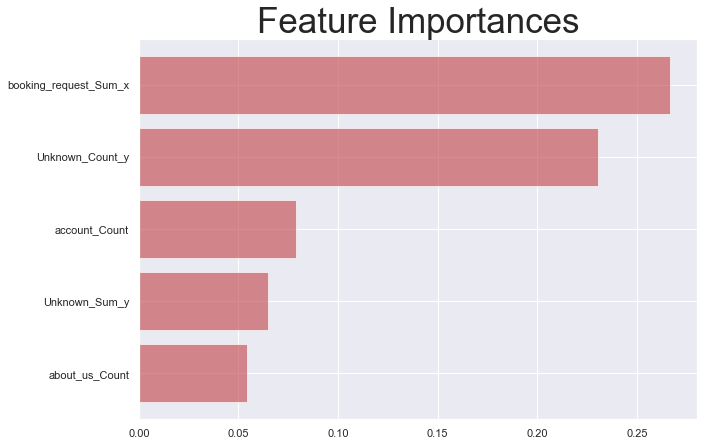

In [200]:
features =train_df.columns
importances = XGB_imp.feature_importances_
indices = (np.argsort(importances))[-5:]
plt.figure(figsize=(10,7))
plt.title('Feature Importances',fontsize=35)
plt.barh(range(len(indices)), importances[indices], color='r', align='center',alpha=.65)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()



**Result on Kaggle**

 <img src="result2.png" width=1000 height=1000 />

### Dataset Benchmark whose submitted notebooks ordered by best score
 <img src="scores.png" width=1000 height=1000 />

# We get a better score ^^ Hooray !!

In [201]:
#Taking the 5 classes with highest probabilities


ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred_imp[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('./datasets/submit4Imp.csv', index=False)